# Final Project

# Title idea: What's in a Game? (reference to Shakespeare soliloquy: "What's in a name?")

For reference here is the Data Science pipeline:

Data Collection -> Data Processing -> Exploratory analysis + data visualization -> Analysis, hypothesis testing, & ML -> Insight & Policy Decision

Eventually delete this box

## Introduction

Steam is the largest digital video game distribution service available to Windows, Mac, and Linux users. Today, Steam has a collection of over 60,000 games available to consumers worldwide. Steam users are able to give either a positive or negative review for each of their owned games, and these reviews are able to be seen by other potential customers to help inform their purchasing decision. Logically, we can conclude that games with a higher positive review percentage are regarded as "better" games, in the sense that they are publicly deemed to be worthy of buying. In this tutorial we will analyze various aspects of games on Steam to try and answer the question:

**What makes a game worth buying?**

## Data Collection

First we gather our Steam Web API key a locally stored text document. A key can be requested from https://steamcommunity.com/dev/apikey.

In [1]:
key = open('key.txt').read()

Next we'll import a few key libraries that we will make use of during data collection.

In [2]:
import requests
import pandas as pd
import numpy as np
import time

Steam has a couple of APIs that can be used to find all sorts of information about a game, including pricing information, genre, number of positive reviews, and much more. But to get this information about a game, first you need to know its designated app ID, as given by Steam. Fortunately, there is a third API provided by Steam that can be used to get a list of app IDs for every single app available on the Steam web store. The term "app" includes games, downloadable content (DLCs), software, videos, and hardware. We are only interested in the app IDs for games, so we will set our API request parameters accordingly. Additionally, only 50,000 results are allowed per request, so we will have to make this request multiple times.

In [3]:
all_ids = []
last_appid = 0

while True:
    URL = "https://api.steampowered.com/IStoreService/GetAppList/v1/"
    PARAMS = {"key": key, "max_results": 50000, "include_games": True, "include_dlc": False, "include_software": False, "include_videos": False, "include_hardware": False, "last_appid": last_appid}
    re = requests.get(url=URL, params=PARAMS).json()["response"]
    for app in re["apps"]:
        all_ids.append(app["appid"])
        
    if "last_appid" not in re.keys():
        break
    else:
        last_appid = re["last_appid"]

With the list of app IDs for every game on the Steam store, we can now make calls to the previously mentioned Steam APIs to get information about every game on the Steam web store. First, we will define a list of the categories of information that we will retrieve from the API response for each game. We also create a list of filters that will be sent as a parameter for the API request.

In [4]:
categories = [
    ['name'],
    ['type'],
    ['steam_appid'],
    ['developers'],
    ['publishers'],
    ['is_free'],
    ['price_overview', 'initial'],
    ['achievements', 'total'],
    ['release_date', 'date'],
    ['metacritic', 'score']
]

filters = ''
for cat in categories:
    filters += cat[0] + ','
filters += 'basic,genres,categories'

Next we define a function to extract this information from each response, which relies on the fact that the API responses are in the JSON format.

In [5]:
def fetch(game_info, categories):
    info = {}
    for category in categories:
        cur_info = game_info
        failed = False
        
        for subpart in category:
            if not failed and subpart in cur_info.keys():
                cur_info = cur_info[subpart]
            else:
                failed = True
        
        if not failed:
            info[' '.join(category)] = cur_info
        else:
            info[' '.join(category)] = np.NaN
    
    if 'genres' in game_info.keys():
        for genre in game_info['genres']:
            info['Genre: ' + genre['description']] = True
    if 'categories' in game_info.keys():
        for genre in game_info['categories']:
            info['Category: ' + genre['description']] = True
    
    return info

As previously mentioned, there are two APIs that will be queried to gather all of the desired information. These APIs seem to have a limit of 200 calls for every 5 minutes, so to account for this we will design special functions for both APIs that will wait until the response code 429 ("Too Many Requests") passes.

In [6]:
def store_query(app_id):
    global filters, key
    
    max_attempts = 11
    attempts = 0
    
    URL = f"http://store.steampowered.com/api/appdetails/?appids={app_id}"
    PARAMS = {'filters': filters, 'l': 'en', 'key': key}
    
    while attempts < max_attempts:
        re = requests.get(url=URL, params=PARAMS)

        if re.status_code != 429:
            break
            
        time.sleep(30)
        attempts += 1
        
    if attempts >= max_attempts:
        print(f"ERROR: Store query timeout on {app_id}")
        return None
    else:
        return re
    
def review_query(app_id):
    max_attempts = 11
    attempts = 0
    
    URL = f"http://store.steampowered.com/appreviews/{app_id}?json=1"
    PARAMS = {'num_per_page': 0, 'language': 'all', 'purchase_type': 'all'}
    
    while attempts < max_attempts:
        re = requests.get(url=URL, params=PARAMS)

        if re.status_code != 429:
            break
            
        time.sleep(30)
        attempts += 1
        
    if attempts >= max_attempts:
        print(f"ERROR: Review query timeout on {app_id}")
        return None
    else:
        return re

With all of that out of the way, we are able to collect the data. We wrap the response parsing in a try-except statement because even though all responses are supposed to be in JSON format, if for whatever reason a response cannot be parsed as a JSON we do not want to halt the program from running.

In [7]:
def generate_df(ids):
    all_info = []
    for app_id in ids:
        # make main api query
        re = store_query(app_id)

        try:
            if re is not None and re.json()[str(app_id)]['success']:
                game_info = re.json()[str(app_id)]['data']
                info = fetch(game_info, categories)

                # make review api query
                re = review_query(app_id)
                if re is not None:
                    summary = re.json()
                    if 'query_summary' in summary.keys():
                        q_summary = summary['query_summary']

                        if 'total_positive' in q_summary:
                            info['total_positive'] = q_summary['total_positive']
                        else:
                            info['total_positive'] = np.NaN

                        if 'total_reviews' in q_summary:
                            info['total_reviews'] = q_summary['total_reviews']
                        else:
                            info['total_reviews'] = np.NaN

                # add the gathered information to the list
                all_info.append(info)
        except:
            print(f"ERROR: JSON parsing error on {app_id}")

    df = pd.DataFrame.from_dict(all_info)
    return df

For practicality reasons, we collected the data beforehand in twenty different batches defined by `np.array_split(all_apps, 20)` and stored the dataframe for each batch as a pickle file so that we could easily load it back up without having to regather the data. Once all batches were completed, the data was then combined with `games_df = pd.concat([df0, df1, df2, ... , df19], ignore_index=True, sort=False)`, and the final combined dataframe was stored locally as "games_df.pkl". This was done because the API request limitations mean that data collection took about 29 hours in total.

In [8]:
df = pd.read_pickle("games_df.pkl") # generate_df(all_ids)
df.head()

,name,type,steam_appid,developers,publishers,is_free,price_overview initial,achievements total,release_date date,metacritic score,...,Genre: Web Publishing,Genre: Accounting,Genre: Video Production,Genre: Game Development,Genre: Photo Editing,Genre: Documentary,Genre: Episodic,Genre: Short,Genre: Tutorial,Genre: 360 Video
0,Counter-Strike,game,10,[Valve],[Valve],False,999.0,NaN,"Nov 1, 2000",88.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Team Fortress Classic,game,20,[Valve],[Valve],False,499.0,NaN,"Apr 1, 1999",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Day of Defeat,game,30,[Valve],[Valve],False,499.0,NaN,"May 1, 2003",79.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Deathmatch Classic,game,40,[Valve],[Valve],False,499.0,NaN,"Jun 1, 2001",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Half-Life: Opposing Force,game,50,[Gearbox Software],[Valve],False,499.0,NaN,"Nov 1, 1999",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Data Processing

The dataframe now as all the information we want, but not all of it is in the desired format. First we replace NaN values from the genre or category columns with false. Values in the genres column are set to NaN if the app was not tagged as part of that genre/category, so this is a logical replacement value.

In [9]:
for col_name in df:
    if col_name.startswith('Genre: ') or col_name.startswith('Category: '):
        df[col_name].fillna(False, inplace=True)

Next we change the release dates to all be in the same format, the pandas datetime format. The parameter `errors='coerce'` means that if pandas cannot figure out what the date format means, then it will set the value to pd.NaT. This is reasonable because there are many apps and not all will use a recognizable format, but we do not want those few exceptions to bring the process to a complete stop. The parameter `infer_datetime_format=True` is used because there is no consistent date format for all Steam pages. The main reason the release date would not be in a format recognized by pandas would be if the date is given in a language other than English.

In [10]:
df['release_date date'] = df['release_date date'].apply(lambda x: pd.to_datetime(x, errors='coerce', infer_datetime_format=True))

C:\Users\bryce\AppData\Local\Temp\ipykernel_26868\3275346979.py:1: UserWarning: Parsing '31/03.2022' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  df['release_date date'] = df['release_date date'].apply(lambda x: pd.to_datetime(x, errors='coerce', infer_datetime_format=True))


Now we define a function to determine positive review percentage for a row. Gives NaN if missing either the total review count or total count of positive reviews.

In [11]:
def positive_perc(row):
    if not np.isnan(row['total_reviews']) and row['total_reviews'] != 0 and not np.isnan(row['total_positive']):
        return row['total_positive'] / row['total_reviews']
    else:
        return np.NaN

With the function defined, we can now add a positive review percentage column to the dataframe.

In [12]:
df['positive_percentage'] = df.apply(positive_perc, axis=1)

We can see that for free games, the price column tends to be NaN. It is reasonable to say that if a game is free, then its price should be 0. We will now define a function to do this for us.

In [13]:
def get_price(row):
    if np.isnan(row['price_overview initial']) and row['is_free']:
        return 0
    else:
        return row['price_overview initial']

We apply this function to the price_overview initial column, and rename the column to just price for the sake of brevity.

In [14]:
df['price_overview initial'] = df.apply(get_price, axis=1)
df.rename({'price_overview initial': 'price'}, axis='columns', inplace=True)

Seems reasonable to replace NaN achievements total with 0

In [15]:
df['achievements total'].fillna(0, inplace=True)

Now let's get an idea of what the tidied up dataframe looks like

In [16]:
df.head()

,name,type,steam_appid,developers,publishers,is_free,price,achievements total,release_date date,metacritic score,...,Genre: Accounting,Genre: Video Production,Genre: Game Development,Genre: Photo Editing,Genre: Documentary,Genre: Episodic,Genre: Short,Genre: Tutorial,Genre: 360 Video,positive_percentage
0,Counter-Strike,game,10,[Valve],[Valve],False,999.0,0.0,2000-11-01,88.0,...,False,False,False,False,False,False,False,False,False,0.974959
1,Team Fortress Classic,game,20,[Valve],[Valve],False,499.0,0.0,1999-04-01,NaN,...,False,False,False,False,False,False,False,False,False,0.858584
2,Day of Defeat,game,30,[Valve],[Valve],False,499.0,0.0,2003-05-01,79.0,...,False,False,False,False,False,False,False,False,False,0.900992
3,Deathmatch Classic,game,40,[Valve],[Valve],False,499.0,0.0,2001-06-01,NaN,...,False,False,False,False,False,False,False,False,False,0.820000
4,Half-Life: Opposing Force,game,50,[Gearbox Software],[Valve],False,499.0,0.0,1999-11-01,NaN,...,False,False,False,False,False,False,False,False,False,0.952906


## Exploratory Data Analysis

Is there some relationship between release date and positive rating percentage? Maybe they just don't make games like they used to, or maybe technological advancements mean that modern games are superior. We'll make a violin plot using matplotlib to compare release year and positive review percentage to try and get some idea.

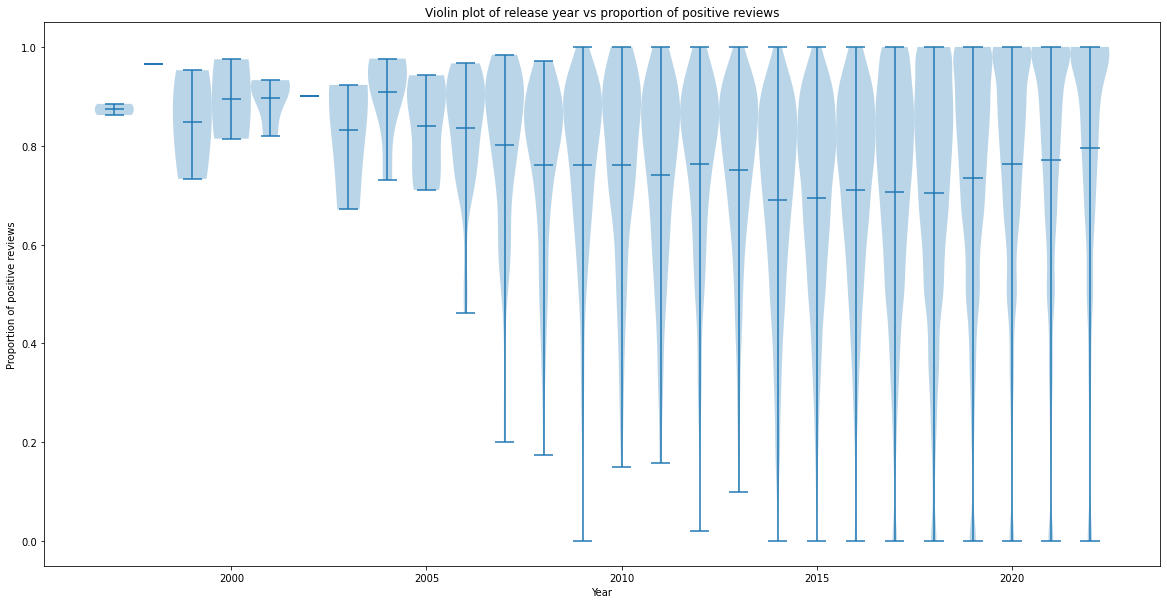

In [17]:
from matplotlib import pyplot as plt

yearly_data = {}
for _, row in df.iterrows():
    if not pd.isnull(row['release_date date']) and not pd.isnull(row['positive_percentage']): # if the date is unknown or if the game has no reviews, it is left out of this plot
        if row['release_date date'].year in yearly_data:
            yearly_data[row['release_date date'].year].append(row['positive_percentage'])
        else:
            yearly_data[row['release_date date'].year] = [row['positive_percentage']]

fig, ax = plt.subplots(figsize=(20,10))
ax.violinplot(list(yearly_data.values()), list(yearly_data.keys()), widths=1, showmeans=True)
ax.set_title("Violin plot of release year vs proportion of positive reviews")
ax.set_xlabel("Year")
ax.set_ylabel("Proportion of positive reviews")
pass

There does not appear to be any significant relationship here. Looking at the means we each year, we do not see a strong trend. A linear relationship is doubtful, so we'll check a different factor.

<hr />

Price?

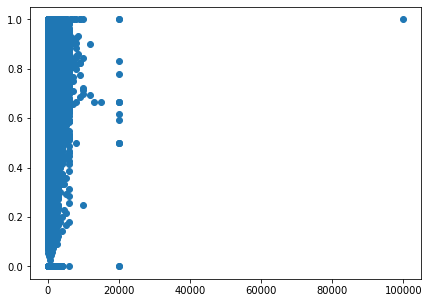

In [18]:
fig, ax = plt.subplots(figsize=(7,5))
ax.scatter(df['price'], df['positive_percentage'])
pass

I think this one is probably a decent one to consider, but that outlier ruins the readability of the plot for now.

<hr />

Metacritic score?

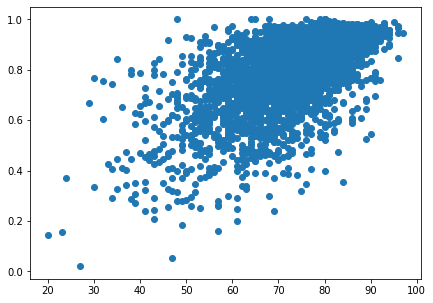

In [19]:
fig, ax = plt.subplots(figsize=(7,5))
ax.scatter(df['metacritic score'], df['positive_percentage'])
pass

This one probably isn't worth bothering with, while the relationship is clear, it is pretty much trivial and not exactly groundbreaking.

I guess if we're talking about "worth buying" then we can frame metacritic score as something like "how does critical acclaim factor in to the value of a game?". Might not be the most insightful, but at least the relationship is pretty obvious.

<hr />

Number of achievements?

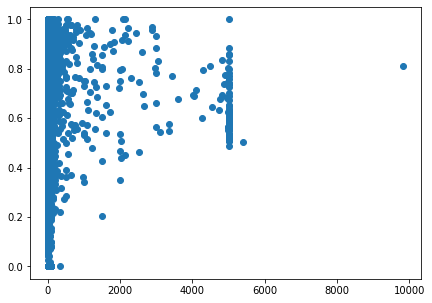

In [20]:
fig, ax = plt.subplots(figsize=(7,5))
ax.scatter(df['achievements total'], df['positive_percentage'])
pass

Relationship here is interesting, but if you look at the scale of the x axis it gets a lot less interesting imo. I bet games with 2000+ achievements were published just for people to pad their achievement count. Also seems like there is a 50,000 barrier or something.

<hr />

Bar chart of average positive review proportion for each genre. Definitely going to be a lot of double/triple/more counting, but I think it is probably fine.

In [21]:
genre_names = []
genre_index = []
genre_count = []
genre_sum_prop = [] # sum of positive proportions for games in this genre

i = 0
for col_name in df:
    if col_name.startswith('Genre: '):
        genre_names.append(col_name[len('Genre: '):])
        genre_index.append(i)
        genre_count.append(0)
        genre_sum_prop.append(0)
    i += 1

for _, row in df.iterrows():
    if not np.isnan(row['positive_percentage']): # if the game doesn't have any reviews it won't be included
        i = 0
        for index in genre_index:
            if row[index]: # evaluates to True if game is in the right genre
                genre_count[i] += 1
                genre_sum_prop[i] += row['positive_percentage']
            i += 1
        
genre_avg_prop = [total / count for total, count in zip(genre_sum_prop, genre_count)]

Now we plot (using cm so bars are all different colors, check https://matplotlib.org/1.2.1/examples/pylab_examples/show_colormaps.html for other colormaps if prism isn't good)

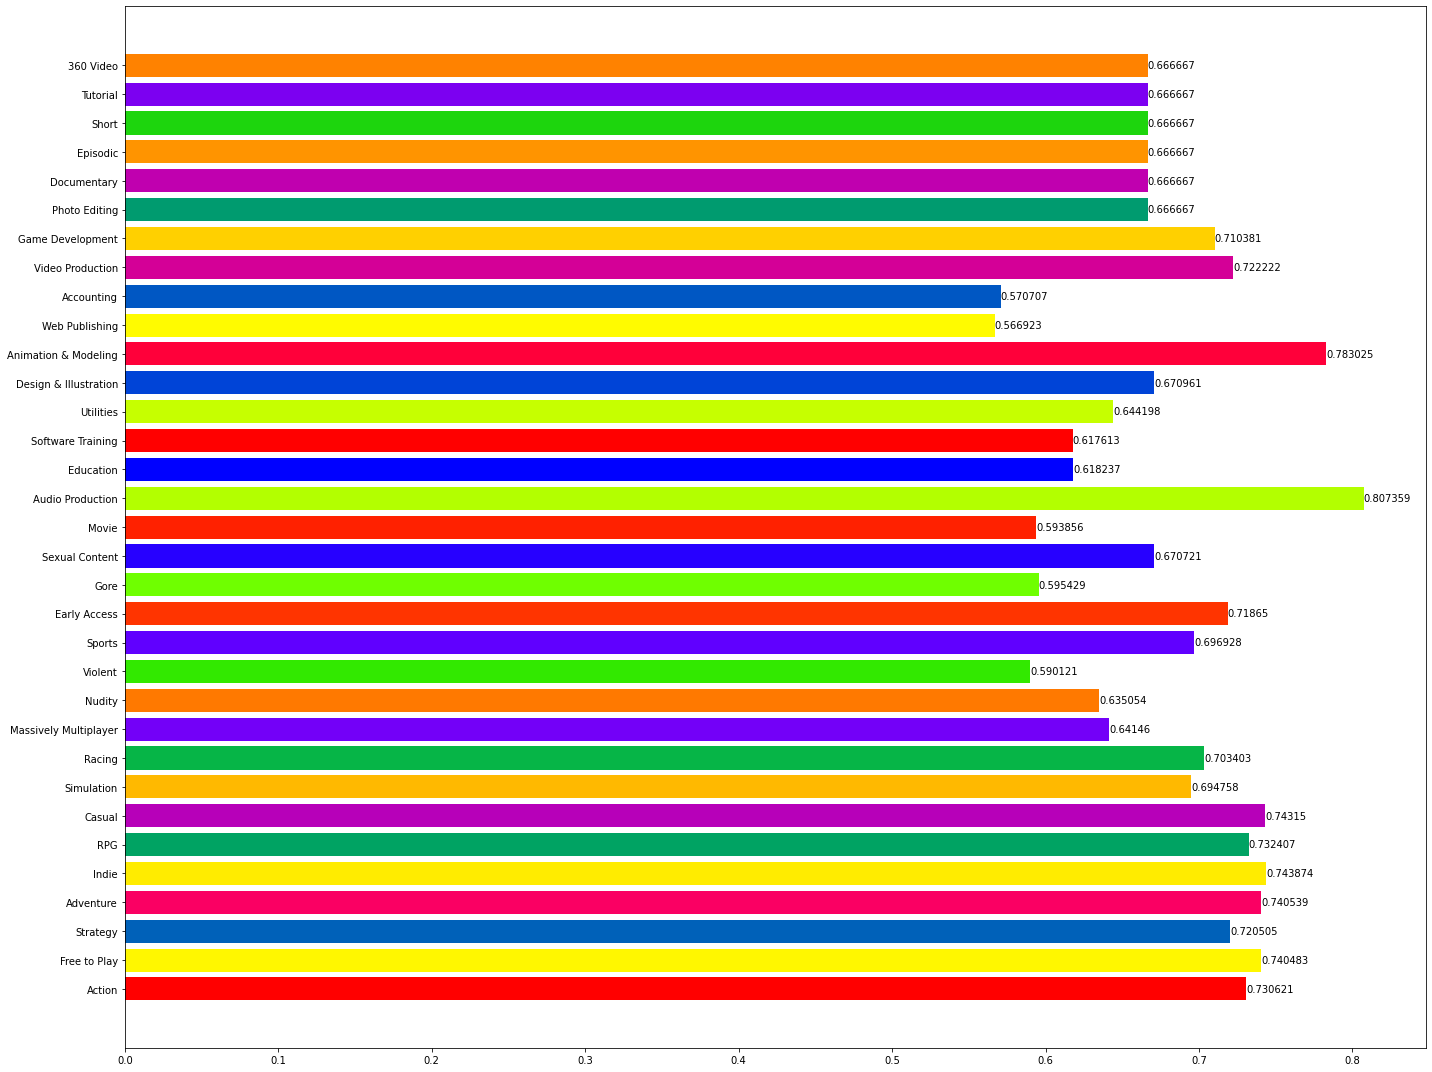

In [34]:
from matplotlib import cm

fig, ax = plt.subplots(figsize=(20,15))


bars = []
for i in range(0, len(genre_names)):
    bars.append(ax.barh(genre_names[i], genre_avg_prop[i], color=cm.prism(1.*i/len(genre_names))))

for bar in bars:
    ax.bar_label(bar)

fig.tight_layout()
pass

Audio production ahead by a not small amount

<hr />

Same thing for categories

In [23]:
cat_names = []
cat_index = []
cat_count = []
cat_sum_prop = [] # sum of positive proportions for games in this category

i = 0
for col_name in df:
    if col_name.startswith('Category: '):
        cat_names.append(col_name[len('Category: '):])
        cat_index.append(i)
        cat_count.append(0)
        cat_sum_prop.append(0)
    i += 1

for _, row in df.iterrows():
    if not np.isnan(row['positive_percentage']): # if the game doesn't have any reviews it won't be included
        i = 0
        for index in cat_index:
            if row[index]: # evaluates to True if game is in the right category
                cat_count[i] += 1
                cat_sum_prop[i] += row['positive_percentage']
            i += 1
        
cat_avg_prop = [total / count for total, count in zip(cat_sum_prop, cat_count)]

plot it

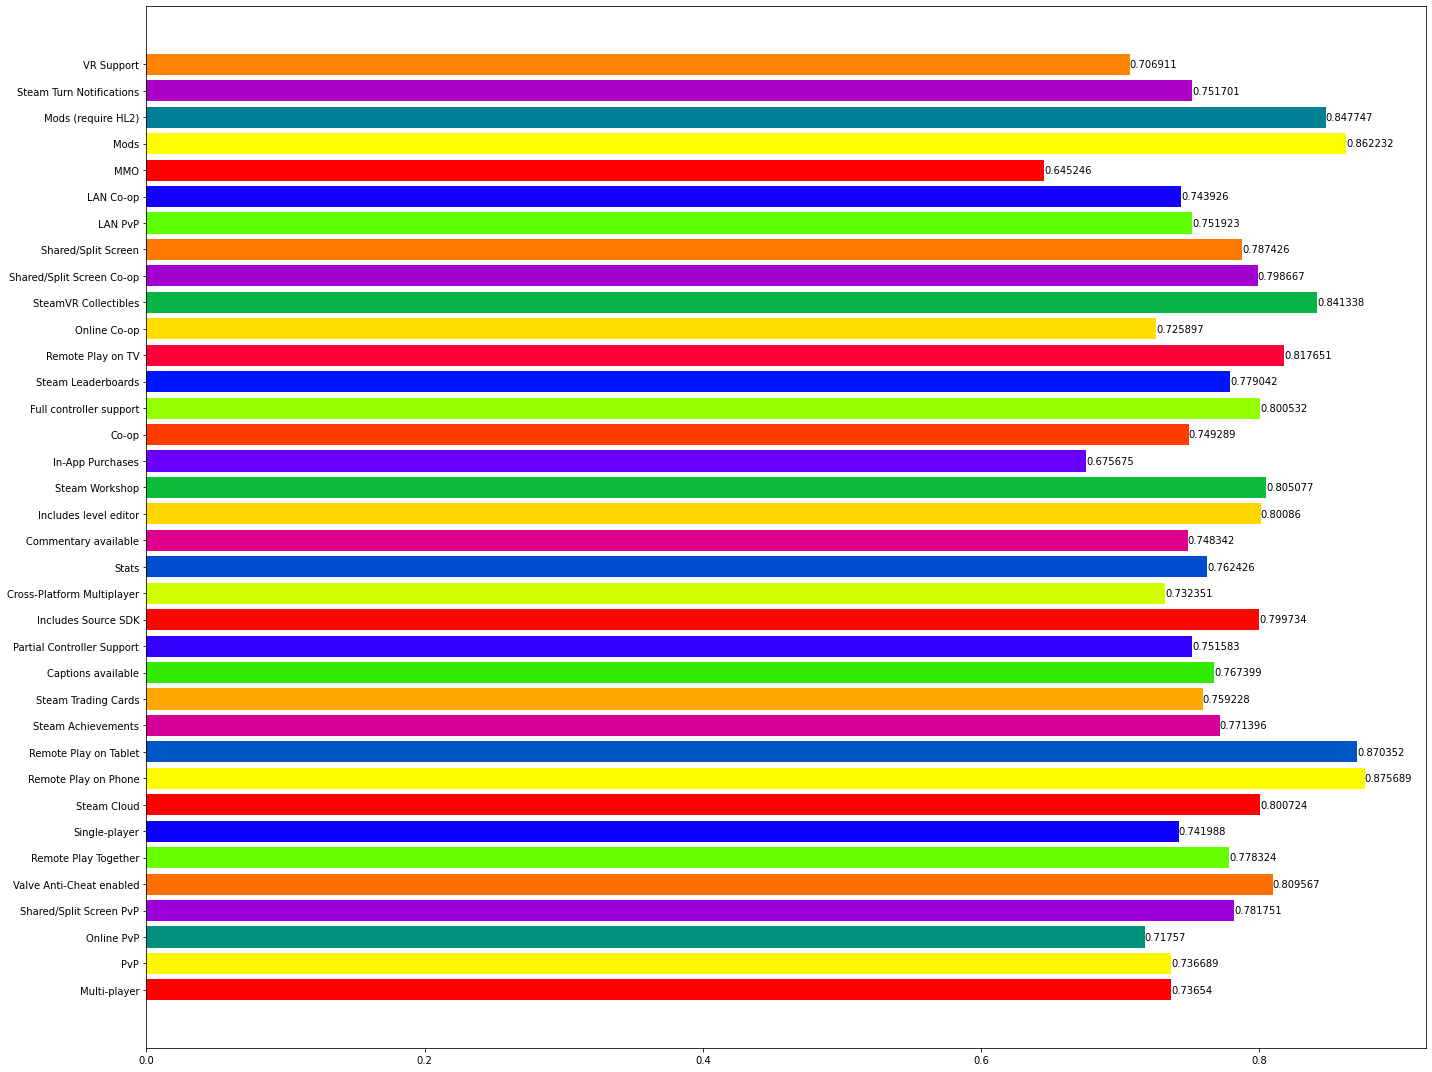

In [35]:
fig, ax = plt.subplots(figsize=(20,15))

bars = []
for i in range(0, len(cat_names)):
    bars.append(ax.barh(cat_names[i], cat_avg_prop[i], color=cm.prism(1.*i/len(cat_names))))
    
for bar in bars:
    ax.bar_label(bar)
    
fig.tight_layout()
pass

Looks like in-app purchases and MMOs are kinda trash. Mods and remote play on phone/tablet seem kinda goated.